In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import os
import time

warnings.filterwarnings('ignore')
np.random.seed(4590)
pd.set_option('max_columns', None)

# Input

In [2]:
input_dir = os.path.join('..', 'input')
file_csv = [file for file in os.listdir(input_dir)\
            if file.endswith('.csv')]
print(file_csv)

['historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
## Pandas@reduce dataframe memory
def reduce_mem_usage(props, fillna=False, fillval=None):
    print('[*]Start')
    start_mem_usg = round(props.memory_usage().sum() / 1024**2, 2)
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # Print current column type
            print("Column: ", col)
            before_type = props[col].dtype
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('>>skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(fillval,inplace=True)  
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < pow(2, 8)-1:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < pow(2, 16)-1:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < pow(2, 32)-1:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            # Print new column type
            after_type = props[col].dtype
            print(">>dtype : {} -> {}".format(before_type, after_type))
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = round(props.memory_usage().sum() / 1024**2, 2) 
    percent = round(100*mem_usg/start_mem_usg, 2)
    print("Memory usage : {}MB -> {}MB ({}% decrease)".format(start_mem_usg, mem_usg, percent))
    return props, NAlist

In [4]:
def read_data(fillna=False, fillval=-999):
    df_train = pd.read_csv(os.path.join(input_dir, 'train.csv'))
    df_test = pd.read_csv(os.path.join(input_dir, 'test.csv'))
    df_hist_trans = pd.read_csv(os.path.join(input_dir, 'historical_transactions.csv'))
    df_new_hist_trans = pd.read_csv(os.path.join(input_dir, 'new_merchant_transactions.csv'))
    df_train, _ = reduce_mem_usage(df_train, fillna=fillna, fillval=fillval)
    df_test, _ = reduce_mem_usage(df_test, fillna=fillna, fillval=fillval)
    df_hist_trans, _ = reduce_mem_usage(df_hist_trans, fillna=fillna, fillval=fillval)
    df_new_hist_trans, _ = reduce_mem_usage(df_new_hist_trans, fillna=False, fillval=-999)
    return df_train, df_test, df_hist_trans, df_new_hist_trans

In [5]:
#fill nan value
def fill_nan_val(df):
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('None', inplace=True)
    df['merchant_id'].fillna('None', inplace=True)

def fix_date(df):
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_year'] = df['purchase_date'].dt.year
    df['purchase_month'] = df['purchase_date'].dt.month
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    #https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    
def fix_category(df):
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2, 'None':3})
    
def fix_others(df):
    #log scale
    df['purchase_amount'] = np.log1p(df['purchase_amount'])

    
def fix_first_date(train, test, trans):
    #first_active_date : train -> trans
    train_test_first = pd.concat([train[['card_id', 'first_active_date']], test[['card_id', 'first_active_date']]])
    return pd.merge(trans, train_test_first, on=['card_id'], how='left')


def fix_transactions(train, test, df):
    fill_nan_val(df)
    fix_date(df)
    fix_category(df)
    fix_others(df)
    df = fix_first_date(train, test, df)
    return df

def fix_train(df):
    #transform to datetime
    df['first_active_date'] = pd.to_datetime(df['first_active_month'])
    df['first_active_year'] = df['first_active_date'].dt.year
    df['first_active_month'] = df['first_active_date'].dt.month
    
    return df

In [6]:
def add_outliers(df):
    df['outliers'] = 0
    df.loc[df['target'] < -30, 'outliers'] = 1

In [7]:
def get_time(start):
    return round(time.time() - start, 2)

In [8]:
def fix_col_name(columns, new=False, flag='new_'):
    if new:
        columns = [flag + col if col != 'card_id' else col for col in columns]
    return columns

In [9]:
def add_purchase_interval(trans): 
    trans['purchase_interval'] = (trans.purchase_date - trans.first_active_date).dt.days // 30
    return trans

In [10]:
def get_base_date(trans, new=False):
    trans = trans[['card_id', 'month_lag', 'purchase_date']].sort_values(by='purchase_date')
    #get max purchase_date
    df = trans.groupby(['card_id']).tail(1)
    df.columns = ['card_id', 'month_lag', 'purchase_date_max']
    df['month_lag'] = pd.to_timedelta(df['month_lag'], unit='M')
    df['base_purchase_date'] = df['purchase_date_max'] - df['month_lag']
    df['base_purhcase_date_year'] = df['base_purchase_date'].dt.year
    df['base_purhcase_date_month'] = df['base_purchase_date'].dt.month
    purchase_date_min = trans[['card_id', 'purchase_date']].groupby(['card_id']).first().reset_index()
    purchase_date_min.columns=['card_id', 'purchase_date_min']
    df = pd.merge(df, purchase_date_min, on='card_id', how='left')
    df = df.drop(['month_lag'], axis=1)
    df.columns = fix_col_name(df.columns, new)
    return df

def add_period(df):
    #hist transactions
    df['period_first_to_min'] = (df['purchase_date_min'] - df['first_active_date']).dt.days // 30
    df['period_min_to_max'] = (df['purchase_date_max'] - df['purchase_date_min']).dt.days
    df['period_max_to_base'] = (df['base_purchase_date'] - df['purchase_date_max']).dt.days // 30
    #new hist transactions
    df['period_max_to_new_min'] = (df['new_purchase_date_min'] - df['purchase_date_max']).dt.days
    df['period_new_min_to_new_max'] = (df['new_purchase_date_max'] - df['new_purchase_date_min']).dt.days
    df['period_min_to_new_max'] = (df['new_purchase_date_max'] - df['purchase_date_min']).dt.days
    return df

def add_base_date(train, test, trans, new=False):
    base_date = get_base_date(trans, new=new)
    train = pd.merge(train, base_date, on=['card_id'], how='left')
    test = pd.merge(test, base_date, on=['card_id'], how='left')
    return train, test

In [11]:
def get_aggregate_features(trans, new=False, flag='new_'):
    #https://www.kaggle.com/gpreda/elo-world-high-score-without-blending
    def get_new_columns(name,aggs):
        return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    
    aggs = {}
    #date features
    for col in ['purchase_month', 'purchase_year', 'weekofyear','dayofweek']:
        aggs[col] = ['nunique']
    for col in ['weekend']:
        aggs[col] = ['mean', 'size']
    #id features
    for col in ['city_id','state_id', 'subsector_id', 'merchant_category_id', 'merchant_id']:
        aggs[col] = ['nunique']
        
    aggs['purchase_amount'] = ['max', 'min','mean', 'sum', 'var', 'std', 'nunique']
    aggs['installments'] = ['max','min','mean', 'sum', 'var', 'std']
    aggs['month_lag'] = ['max','min', 'mean', 'nunique']
    aggs['authorized_flag'] = ['mean', 'sum', 'std', 'var']
    aggs['card_id'] = ['size']
    aggs['purchase_interval'] = ['mean', 'std', 'var', 'min', 'max']
    aggs['category_1'] = ['mean', 'sum', 'nunique']
    aggs['category_2'] = ['mean', 'sum', 'nunique']
    aggs['category_3'] = ['mean', 'sum', 'nunique']
    aggs['purchase_date'] = ['min', 'max']
    aggs['month_diff'] = ['mean']
    
    '''
    for col in ['category_2','category_3']:
        trans[col+'_mean'] = trans.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']
    '''
    
    new_columns = get_new_columns('hist',aggs)
    df_hist_trans_group = trans.groupby('card_id').agg(aggs)
    df_hist_trans_group.columns = new_columns
    df_hist_trans_group.reset_index(drop=False,inplace=True)
    return df_hist_trans_group

def add_aggregate_features(train, test, trans, percentage, new=False, flag='new_'):
    df = get_aggregate_features(trans, new, flag=flag)
    
    if percentage:
        df['hist_merchant_unique_by_size'] = df['hist_merchant_id_nunique'] // df['hist_card_id_size']
        df['hist_merchant_category_unique_by_size'] = df['hist_merchant_category_id_nunique'] // df['hist_card_id_size']
        df['hist_state_unique_by_size'] = df['hist_state_id_nunique'] // df['hist_card_id_size']
        df['hist_city_unique_by_size'] = df['hist_city_id_nunique'] // df['hist_card_id_size']
        df['hist_purchase_amount_unique_by_size'] = df['hist_purchase_amount_nunique'] // df['hist_card_id_size']
        df['hist_subsector_unique_by_size'] = df['hist_subsector_id_nunique'] // df['hist_card_id_size']
        df['hist_category_1_unique_by_size'] = df['hist_category_1_nunique'] // df['hist_card_id_size']
        df['hist_category_2_unique_by_size'] = df['hist_category_2_nunique'] // df['hist_card_id_size']
        df['hist_category_3_unique_by_size'] = df['hist_category_3_nunique'] // df['hist_card_id_size']
    
    
    df.columns = fix_col_name(df.columns, new, flag=flag)
    train = pd.merge(train, df, on=['card_id'], how='left')
    test = pd.merge(test, df, on=['card_id'], how='left')
    return train, test

In [12]:
def add_additional_features(df):
    df['total_card_id_size'] = df['hist_card_id_size'] + df['new_hist_card_id_size']
    df['total_purchase_amount'] = df['hist_purchase_amount_sum'] + df['new_hist_purchase_amount_sum']
    df['total_period'] = df['period_min_to_max'] + df['period_min_to_new_max']
    
    df['avg_purchase_amount_per_period'] = df['hist_purchase_amount_sum'] // df['period_min_to_max']
    df['avg_size_per_period'] = df['hist_card_id_size'] // df['period_min_to_max']
    df['avg_weekend_per_size'] = df['hist_weekend_size'] // df['hist_card_id_size']
    
    df['new_avg_purchase_amount_per_period'] = df['new_hist_purchase_amount_sum'] // df['period_new_min_to_new_max']
    df['new_avg_size_per_period'] = df['new_hist_card_id_size'] // df['period_new_min_to_new_max']
    df['new_avg_weekend_per_size'] = df['new_hist_weekend_size'] // df['new_hist_card_id_size']
    
    df['total_avg_purchase_amount_per_period'] = df['total_card_id_size'] // df['total_period']
    df['total_avg_size_per_period'] = (df['hist_card_id_size']+df['new_hist_card_id_size']) // df['total_period']
    df['total_avg_weekend_per_size'] = (df['hist_weekend_size']+df['new_hist_weekend_size']) // df['total_card_id_size']
    
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['first_active_month'] = df['first_active_month'].astype(int)
    return df

In [13]:
def get_unique_max_size_features(trans, new=False, flag='new_'):
    df = trans[['card_id']].drop_duplicates()
    for col in ['purchase_amount', 'merchant_id', 'city_id']:
        unique_df = trans.groupby(['card_id', col]).size().reset_index()
        unique_df.columns = ['card_id', col, col+'_unique_size']
        unique_df = unique_df.groupby(['card_id'])[col+'_unique_size'].max().reset_index()
        df = pd.merge(df, unique_df, on=['card_id'], how='left')
        del unique_df
    df.columns = fix_col_name(df.columns, new, flag)
    return df

def add_unique_max_size_features(train, test, trans, new=False, flag='new_'):
    unique_size = get_unique_max_size_features(trans, new, flag)
    train = pd.merge(train, unique_size, on=['card_id'], how='left')
    test = pd.merge(test, unique_size, on=['card_id'], how='left')
    return train, test

In [14]:
def get_data(df_train, df_test, df_hist_trans, df_new_hist_trans, lag_features=False):
    fillna=False
    fillval=-999
    ###################################################################################
    #fill nan / add 'first_active_date' / to_datetime
    print('[*]Start preprocessing')
    start = time.time()
    df_train = fix_train(df_train)
    df_test = fix_train(df_test)
    input_train = df_train.copy()
    input_test = df_test.copy()
    print('[{:>6}s]Make input data'.format(get_time(start)))
    gc.collect()
    
    ###################################################################################
    start = time.time()
    input_train, input_test = add_unique_max_size_features(input_train, input_test, pd.concat([df_hist_trans, df_new_hist_trans]), new=False)
    print('[{:>6}s]Add unique size features'.format(get_time(start)))
    ###################################################################################
    start = time.time()    
    df_hist_trans = fix_transactions(df_train, df_test, df_hist_trans)
    df_hist_trans = add_purchase_interval(df_hist_trans)
    input_train, input_test = add_aggregate_features(input_train, input_test, df_hist_trans,
                                                     new=False, percentage=True)
    
    df_new_hist_trans = fix_transactions(df_train, df_test, df_new_hist_trans)
    df_new_hist_trans = add_purchase_interval(df_new_hist_trans)
    input_train, input_test = add_aggregate_features(input_train, input_test, df_new_hist_trans,
                                                     new=True, percentage=True)
    
    del df_train, df_test
    gc.collect()
    
    '''
    input_train, input_test = add_aggregate_features(input_train, input_test, pd.concat([df_hist_trans, df_new_hist_trans]),
                                                     new=True, percentage=True, flag='total_')
    '''
    print('[{:>6}s]Add aggregate features'.format(get_time(start)))
    gc.collect()
    ###################################################################################
    start = time.time()
    input_train, input_test = add_base_date(input_train, input_test, df_hist_trans, new=False)
    input_train, input_test = add_base_date(input_train, input_test, df_new_hist_trans, new=True)
    input_train = add_period(input_train)
    input_test = add_period(input_test)
    print('[{:>6}s]Add period date'.format(get_time(start)))
    gc.collect()
    ###################################################################################
    start = time.time()    
    input_train = add_additional_features(input_train)
    input_test = add_additional_features(input_test)
    print('[{:>6}s]Add additional features'.format(get_time(start)))
    gc.collect()
    ###################################################################################
    start = time.time()
    add_outliers(input_train)
    print(input_train.shape, input_test.shape)
    print('[{:>6}s]Add outliers_features'.format(get_time(start)))
    
    gc.collect()
    
    return input_train, input_test

In [15]:
start = time.time()
df_train, df_test, df_hist_trans, df_new_hist_trans = read_data()
gc.collect()
print('[{:>6}s]Read data'.format(get_time(start)))

[*]Start
Column:  feature_1
>>dtype : int64 -> uint8
Column:  feature_2
>>dtype : int64 -> uint8
Column:  feature_3
>>dtype : int64 -> uint8
Column:  target
>>dtype : float64 -> float32
___MEMORY USAGE AFTER COMPLETION:___
Memory usage : 9.24MB -> 4.43MB (47.94% decrease)
[*]Start
Column:  feature_1
>>dtype : int64 -> uint8
Column:  feature_2
>>dtype : int64 -> uint8
Column:  feature_3
>>dtype : int64 -> uint8
___MEMORY USAGE AFTER COMPLETION:___
Memory usage : 4.72MB -> 2.24MB (47.46% decrease)
[*]Start
Column:  city_id
>>dtype : int64 -> int16
Column:  installments
>>dtype : int64 -> int16
Column:  merchant_category_id
>>dtype : int64 -> int16
Column:  month_lag
>>dtype : int64 -> int8
Column:  purchase_amount
>>dtype : float64 -> float32
Column:  category_2
>>skip category_2 cause of NA value
Column:  state_id
>>dtype : int64 -> int8
Column:  subsector_id
>>dtype : int64 -> int8
___MEMORY USAGE AFTER COMPLETION:___
Memory usage : 3109.54MB -> 1915.7MB (61.61% decrease)
[*]Start
Colu

In [16]:
print('[*]df_train          : {}'.format(df_train.shape))
print('[*]df_test           : {}'.format(df_test.shape))
print('[*]df_hist_trans     : {}'.format(df_hist_trans.shape))
print('[*]df_new_hist_trans : {}'.format(df_new_hist_trans.shape))
print('[*]hist/new hist perc: {:.2f}%'.format(df_hist_trans.shape[0]/df_new_hist_trans.shape[0]))

[*]df_train          : (201917, 6)
[*]df_test           : (123623, 5)
[*]df_hist_trans     : (29112361, 14)
[*]df_new_hist_trans : (1963031, 14)
[*]hist/new hist perc: 14.83%


In [17]:
tmp = False
if tmp:
    lag_features = True
    input_train, input_test = get_data(df_train, df_test,
                                       df_hist_trans, df_new_hist_trans, lag_features=lag_features)
    print('[*]input_train : {}'.format(input_train.shape))
    print('[*]input_test : {}'.format(input_test.shape))
else:
    input_train = pd.read_csv('input_train.csv')
    input_test = pd.read_csv('input_test.csv')
    df_train = fix_train(df_train)
    df_test = fix_train(df_test)
    df_hist_trans = fix_transactions(df_train, df_test, df_hist_trans)
    df_hist_trans = add_purchase_interval(df_hist_trans)
    df_new_hist_trans = fix_transactions(df_train, df_test, df_new_hist_trans)
    df_new_hist_trans = add_purchase_interval(df_new_hist_trans)
    del df_train,df_test
    gc.collect()
    input_train, input_test = add_aggregate_features(input_train, input_test, pd.concat([df_hist_trans, df_new_hist_trans]),
                                                         new=True, percentage=True, flag='total_')
    print('[*]input_train : {}'.format(input_train.shape))
    print('[*]input_test : {}'.format(input_test.shape))

[*]input_train : (201917, 218)
[*]input_test : (123623, 216)


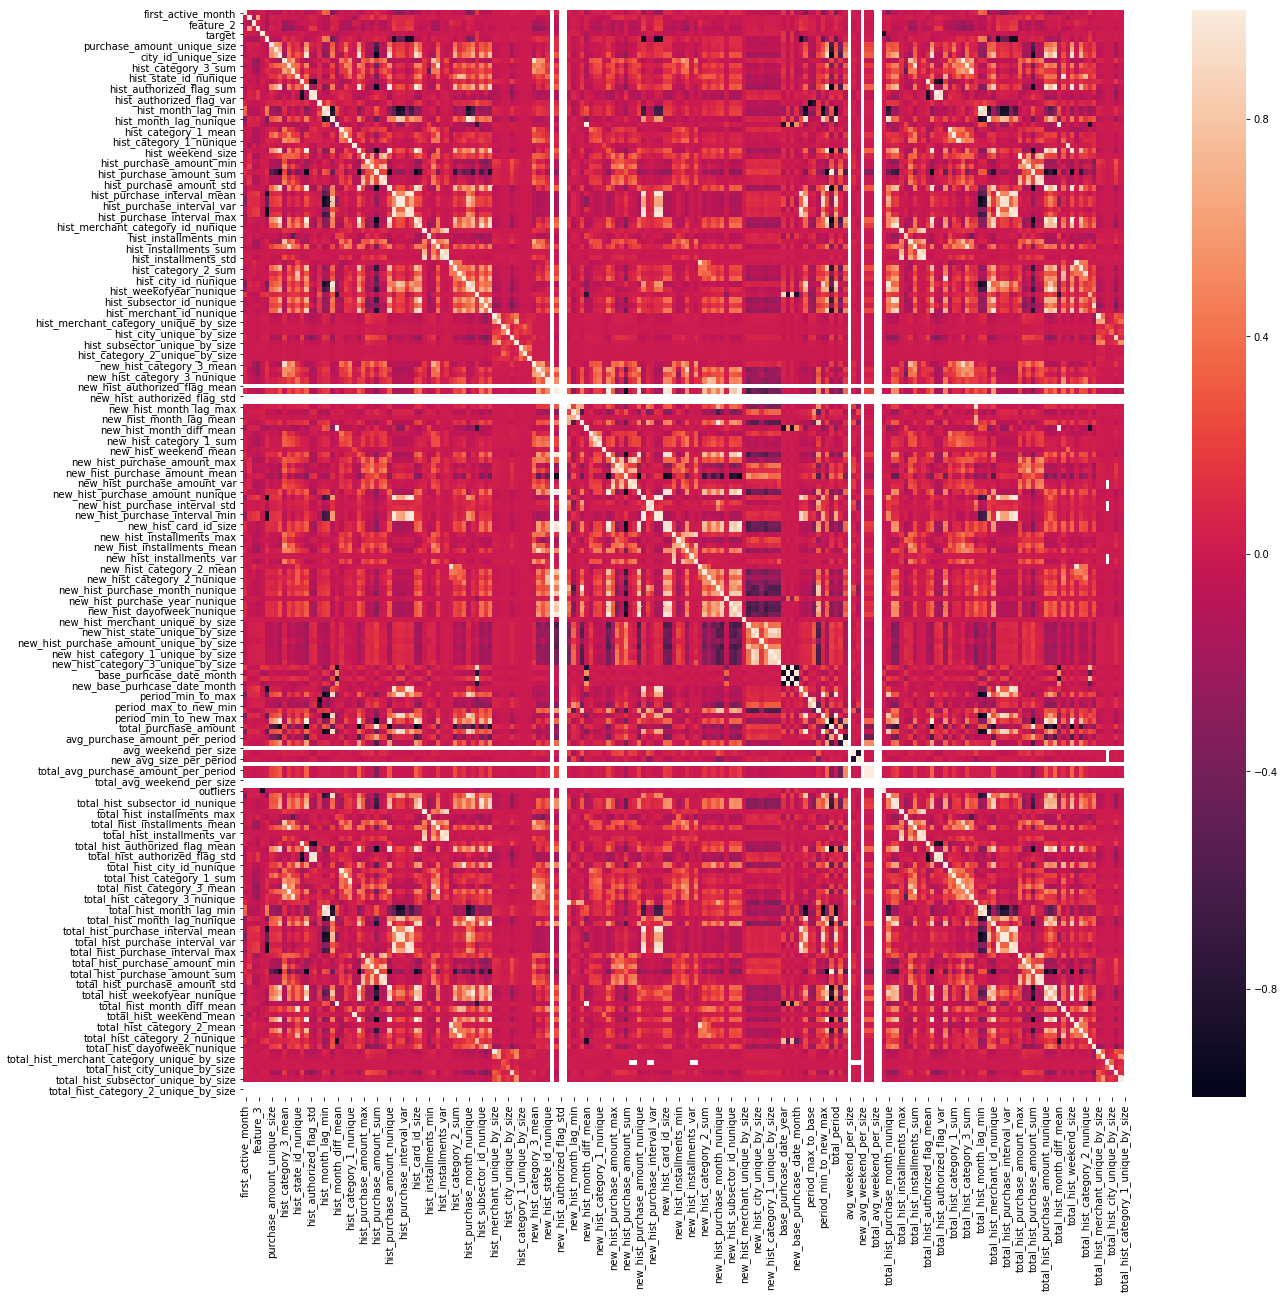

In [18]:
plt.figure(figsize=(20, 20))
sns.heatmap(input_train.corr())

In [19]:
input_train.corr().mean().sort_values()

total_hist_purchase_amount_sum              -0.110401
total_purchase_amount                       -0.110219
hist_purchase_amount_sum                    -0.108906
total_hist_month_lag_min                    -0.081181
hist_month_lag_min                          -0.081181
hist_month_lag_mean                         -0.064649
total_hist_month_lag_mean                   -0.063715
new_hist_purchase_amount_sum                -0.060077
first_active_year                           -0.052290
avg_purchase_amount_per_period              -0.050150
new_hist_merchant_category_unique_by_size   -0.040238
new_hist_subsector_unique_by_size           -0.039400
period_max_to_new_min                       -0.038264
total_hist_installments_min                 -0.034787
new_hist_month_diff_mean                    -0.030714
total_hist_month_diff_mean                  -0.028826
hist_month_diff_mean                        -0.028676
feature_3                                   -0.027321
hist_authorized_flag_var    

In [20]:
useless_columns = list(input_train.select_dtypes(include=[np.datetime64, object]).columns.values)
useless_columns.extend(['target', 'outliers'])
df_train_columns = [c for c in input_train.columns if c not in useless_columns]
target = input_train['target']
print('[*]Use columns : {}'.format(len(df_train_columns)))

[*]Use columns : 202


In [21]:
param = {'num_leaves': 30, #31 -> 30
         'min_data_in_leaf': 50, #30 -> 50
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005, 
         "min_child_samples": 20, #20
         "boosting": "gbdt",
         "feature_fraction": 0.95, #0.9 -> 0.95
         "bagging_freq": 1,
         "bagging_fraction": 0.6, #0.9 -> 0.6
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(input_train))
predictions = np.zeros(len(input_test))
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(input_train,input_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(input_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(input_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(input_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions += clf.predict(input_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
score = np.sqrt(mean_squared_error(oof, target))
print('[*]score : {}'.format(score))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.50252	valid_1's rmse: 3.67561
Early stopping, best iteration is:
[1702]	training's rmse: 3.43313	valid_1's rmse: 3.67156
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.51313	valid_1's rmse: 3.64205
Early stopping, best iteration is:
[1572]	training's rmse: 3.45752	valid_1's rmse: 3.63718
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.50124	valid_1's rmse: 3.67109
Early stopping, best iteration is:
[1668]	training's rmse: 3.43595	valid_1's rmse: 3.66686
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.5084	valid_1's rmse: 3.65941
Early stopping, best iteration is:
[1736]	training's rmse: 3.43779	valid_1's rmse: 3.65552
fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.50442	valid_1's rmse: 3.66148
[2000]	

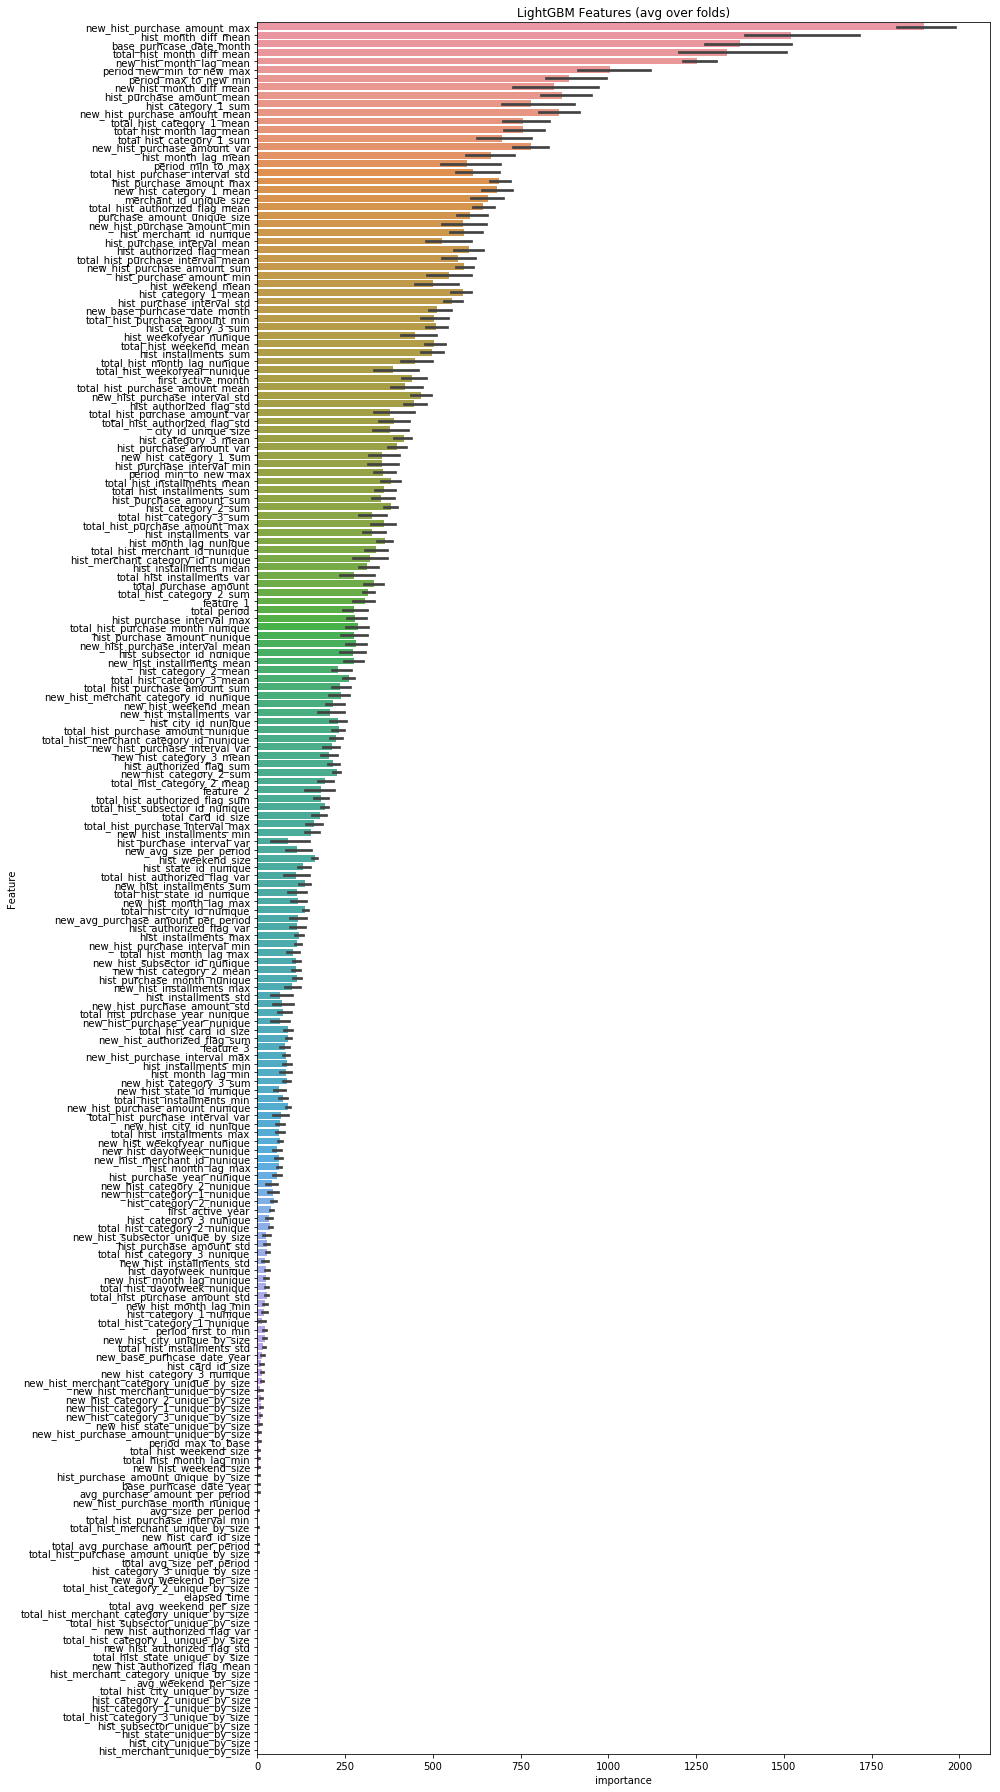

In [22]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances.png')

In [ ]:
sorted_features = best_features.groupby('Feature').importance.mean().reset_index().sort_values(by='importance', ascending=False).Feature.values

In [38]:
[x for x in sorted_features[:15] if 'total' in x]

['total_hist_month_diff_mean',
 'total_hist_category_1_mean',
 'total_hist_month_lag_mean',
 'total_hist_category_1_sum']

In [39]:
[x for x in sorted_features[:15] if 'new' in x]

['new_hist_purchase_amount_max',
 'new_hist_month_lag_mean',
 'period_new_min_to_new_max',
 'period_max_to_new_min',
 'new_hist_purchase_amount_mean',
 'new_hist_month_diff_mean',
 'new_hist_purchase_amount_var']

In [49]:
[x for x in sorted_features[:15]  if 'new' not in x and 'total' not in x]

['hist_month_diff_mean',
 'base_purhcase_date_month',
 'hist_purchase_amount_mean',
 'hist_category_1_sum']

In [23]:
def record_result(score, columns, result_df):
    df_columns = ['feature_cols', 'date_cols', 'rate_cols', 'hist_cols', 'avg_cols', 'others_cols',
                  'feature_cols_size', 'date_cols_size', 'rate_cols_size', 'hist_cols_size', 'avg_cols_size', 'others_cols_size',
                  'col_size', 'total_size', 'size_flag', 'score']
    df = None
    if os.path.exists(result_df):
        df = pd.read_csv(result_df)
    else:
        df = pd.DataFrame(columns = df_columns)
    feature_cols = []
    rate_cols = []
    date_cols = []
    hist_cols = []
    avg_cols = []
    others_cols = []
    
    for col in columns:
        if 'hist' in col:
            hist_cols.append(col)
        elif 'avg' in col:
            avg_cols.append(col)
        elif 'feature' in col:
            feature_cols.append(col)
        elif 'rate' in col:
            rate_cols.append(col)
        elif len([x for x in ['first', 'date', 'period'] if x in col]):
            date_cols.append(col)
        else:
            others_cols.append(col)
    
    data = {}
    col_size = 0
    for val, key in zip([feature_cols, date_cols, rate_cols, hist_cols, avg_cols, others_cols],
                   ['feature_cols', 'date_cols', 'rate_cols', 'hist_cols', 'avg_cols', 'others_cols']):
        size = len(val) if len(val) else 0
        col_size += size
        data['{}_size'.format(key)] = size
        if val:
            val = ','.join(val)
        else:
            val = ''
        
        data[key] = val
    data['col_size'] = col_size
    data['total_size'] = len(columns)
    data['size_flag'] = col_size == len(columns)
    data['score'] = score
    df = df.append(data, ignore_index=True)
    df.to_csv(result_df, index=False)

In [24]:
result_df = os.path.join('..', 'output', 'record_result.csv')
record_result(score, df_train_columns, result_df)
tmp = pd.read_csv(result_df)
tmp

,feature_cols,date_cols,rate_cols,hist_cols,avg_cols,others_cols,feature_cols_size,date_cols_size,rate_cols_size,hist_cols_size,avg_cols_size,others_cols_size,col_size,total_size,size_flag,score
0,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...","rate_mean_std,rate_sum_std","hist_state_id_nunique,hist_installments_max,hi...","avg_purchase_amount_per_period,avg_size_per_pe...","purchase_min_max_devide,purchase_amount_unique...",3,7,2,45,3,11,71,71,True,3.742926
1,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...","rate_mean_std,rate_sum_std","hist_state_id_nunique,hist_installments_max,hi...","avg_purchase_amount_per_period,avg_size_per_pe...","purchase_min_max_devide,purchase_amount_unique...",3,7,2,45,2,11,70,70,True,3.742926
2,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...","rate_mean_std,rate_sum_std","hist_state_id_nunique,hist_installments_max,hi...","avg_purchase_amount_per_period,avg_size_per_pe...","purchase_amount_unique_size,percentage_merchan...",3,7,2,45,2,10,69,69,True,3.742589
3,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...","rate_mean_std,rate_sum_std","hist_installments_max,hist_installments_min,hi...","avg_purchase_amount_per_period,avg_size_per_pe...","purchase_amount_unique_size,percentage_merchan...",3,7,2,47,2,7,68,68,True,3.741510
4,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...","rate_mean_std,rate_sum_std","hist_state_id_nunique,hist_category_3_mean,his...","avg_purchase_amount_per_period,avg_size_per_pe...","purchase_amount_unique_size,percentage_merchan...",3,7,2,47,2,4,65,65,True,3.741108
5,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...","rate_mean_std,rate_sum_std","hist_weekend_mean,hist_weekend_size,hist_state...","avg_purchase_amount_per_period,avg_size_per_pe...","purchase_min_max_devide,purchase_amount_unique...",3,7,2,45,2,11,70,70,True,3.741799
6,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...","rate_mean_std,rate_sum_std","hist_weekend_mean,hist_weekend_size,hist_state...","avg_purchase_amount_per_period,avg_size_per_pe...","purchase_amount_unique_size,percentage_merchan...",3,7,2,45,2,5,64,64,True,3.741865
7,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...","rate_mean_std,rate_sum_std","hist_weekend_mean,hist_weekend_size,hist_state...","avg_purchase_amount_per_period,avg_size_per_pe...","purchase_amount_unique_size,percentage_merchan...",3,7,2,47,2,5,66,66,True,3.741381
8,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...","rate_mean_std,rate_sum_std","hist_dayofweek_nunique,hist_merchant_id_nuniqu...","avg_purchase_amount_per_period,avg_size_per_pe...","purchase_amount_unique_size,merchant_id_unique...",3,7,2,47,2,7,68,68,True,3.742120
9,"feature_1,feature_2,feature_3","first_active_month,first_active_year,base_purh...",NaN,"hist_dayofweek_nunique,hist_merchant_id_nuniqu...","avg_purchase_amount_per_period,avg_weekend_per...","purchase_min_max_devide,purchase_amount_unique...",3,7,0,47,2,6,65,65,True,3.740709


In [25]:
sub_df = pd.DataFrame({"card_id":input_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_hist&new_aggregate_additional_total_useless.csv", index=False)
print('done')

done
